# Install libraries

In [ ]:
!pip install -U pyLDAvis
!pip install scispacy
!pip install tika
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.3.0/en_core_sci_lg-0.3.0.tar.gz

Requirement already up-to-date: pyLDAvis in /usr/local/lib/python3.6/dist-packages (3.2.0)
  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.3.0/en_core_sci_lg-0.3.0.tar.gz
  Created wheel for en-core-sci-lg: filename=en_core_sci_lg-0.3.0-cp36-none-any.whl size=502173407 sha256=8e616da79923108af015178cdca0dcc8241e526332763aefa4e86da57dafdb39
  Stored in directory: /root/.cache/pip/wheels/86/e8/9b/7eca1465cb6997429390e40ac9d4e1890863b0395deaddf2f0
Successfully built en-core-sci-lg


# Import Libraries

In [ ]:
import pandas as pd
import numpy as np

import re
import string

import scispacy
import spacy
import en_core_web_sm

import gensim
from gensim import corpora

import os
from tika import parser

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data load and exploration

In [ ]:
df = pd.read_csv("/content/1905_85Test.csv")
df.shape

FileNotFoundError: ignored

In [ ]:
df.head()

In [ ]:
print(df.Abstract[0])

# Data load from 40 different PDFs and exploration 

In [ ]:
path = "/content" # path directory
directory=os.path.join(path)
pdf_text = ''
for r,d,f in os.walk(directory): #going through subdirectories
    for file in f:
        if ".pdf" in file:  # reading only PDF files
            file_join = os.path.join(r, file)   #getting full path 
            file_data = parser.from_file(file_join)     # parsing the PDF file 
            print(file_join)
            pdf_text = pdf_text + ' ' + file_data['content'].strip()             # read the content 

/content/Atherosclerosis 4.pdf
/content/pregnancy.pdf
/content/pregnancy 5.pdf
/content/asthma 3.pdf
/content/Food Allergy.pdf
/content/Anaphylaxis.pdf
/content/dogs 3.pdf
/content/asthma 2.pdf
/content/Atherosclerosis 5.pdf
/content/Anaphylaxis 2.pdf
/content/Kidney 3.pdf
/content/Urticaria 2.pdf
/content/pediatric 3.pdf
/content/pediatric 4.pdf
/content/Urticaria 4.pdf
/content/dogs.pdf
/content/dogs 5.pdf
/content/Food Allergy 2.pdf
/content/teeth.pdf
/content/Food allergy 5.pdf
/content/Anaphylaxis 3.pdf
/content/Urticaria.pdf
/content/teeth 3.pdf
/content/Urticaria 5.pdf
/content/dogs 2.pdf
/content/pediatric.pdf
/content/Food Allergy 3.pdf
/content/Atherosclerosis 2.pdf
/content/Kidney 4.pdf
/content/teeth 4.pdf
/content/Kidney.pdf
/content/pediatric 5.pdf
/content/asthma.pdf
/content/asthma 4.pdf
/content/asthma 5.pdf
/content/teeth 5.pdf
/content/pregnancy 4.pdf
/content/pregnancy 3.pdf
/content/pediatric 2.pdf
/content/teeth 2.pdf
/content/Urticaria 3.pdf
/content/Anaphylaxis 

In [ ]:
len(pdf_text)

3243623

# Preprocessing predefined functions

Converting into Lowercase - Done!

Removing white spaces - Done!

Removing punctuation - Done!

Removing numbers - Done!

Removing words with length < 3 - Done!

Stopwords handling - Done!

Removing additional user defined words - Done!

Tokenization - Done!

Lemmatisation - Done!

Bigram Trigram modelling - Done!

In [ ]:
# Function to pre-process text
def clean_text(text): 
    # Remove punctuation 
    punct = string.punctuation
    #punct = punct.replace('-','')
    delete_dict = {sp_character: '' for sp_character in punct} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    # Remove white spaces
    textArr= text1.split() 
    # Remove words containing numbers
    text2 = [w for w in textArr if not any(n.isdigit() for n in w)]
    # Remove words with length < 3 and numbers 
    text3 = ' '.join([w for w in text2 if ( not w.isdigit() and ( not w.isdigit() and len(w)>3))])
    # Converting into Lowercase
    return text3.lower()

In [ ]:
stop_words = stopwords.words('english')
special_words = ['mast','cell','cells','however','also','since','various','normal','crossref','pubmed','therefore','another','whether','may',"’",'author','study','observe','find','scrip','journal','manuscript','review','figure','result','suggest']
stop_words.extend(special_words)

# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

In [ ]:
# Convert sentence to a list of words / Tokens
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [ ]:
# Function to create bigrams and trigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [ ]:
pip install en_core_sci_lg

In [ ]:
# Lemmatization only allowing nouns, adjectives, verbs and adverbs

#import en_core_sci_sm. # A full spaCy pipeline for biomedical data.
#nlp = en_core_sci_sm.load()

#import en_core_sci_lg # A full spaCy pipeline for biomedical data with a larger vocabulary and 600k word vectors.
nlp = en_core_web_sm.load()

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Data Cleaning for Abstract list

In [ ]:
# Data cleaning
df['Abstract'] = df['Abstract'].apply(clean_text)
print(df.Abstract[0])

three antiallergic drugs doxantrazole well disodium cromoglycate inhibited igemediated reaction triggered homologous antigen have antagonistic effect histamine itself moreover drugs examined caused vitro inhibition antigenmediated histamine release from peritoneal mast cells chopped lung tissue sensitized rats producing antibodies doxantrazole synergistic effect inhibition histamine release isoproterenol whereas other drugs were devoid this capacity inhibited ionophore induced histamine release have effect histamine release which triggered antigen


In [ ]:
# remove stopwords from the text
df['Abstract'] = df['Abstract'].apply(remove_stopwords)
print(df.Abstract[:5])

0    three antiallergic drugs doxantrazole well dis...
1    decision made therapy atopic eczema complex pa...
2    transplantation ascitic mastocytoma intraderma...
3    vitro assays release histamine peritoneal show...
4    peritoneal concentrate colloidal gold particle...
Name: Abstract, dtype: object


In [ ]:
# tokenisation
token_list = list(sent_to_words(df['Abstract']))
print(token_list[:5])

[['three', 'antiallergic', 'drugs', 'doxantrazole', 'well', 'disodium', 'cromoglycate', 'inhibited', 'igemediated', 'reaction', 'triggered', 'homologous', 'antigen', 'antagonistic', 'effect', 'histamine', 'moreover', 'drugs', 'examined', 'caused', 'vitro', 'inhibition', 'antigenmediated', 'histamine', 'release', 'peritoneal', 'chopped', 'lung', 'tissue', 'sensitized', 'rats', 'producing', 'antibodies', 'doxantrazole', 'synergistic', 'effect', 'inhibition', 'histamine', 'release', 'isoproterenol', 'whereas', 'drugs', 'devoid', 'capacity', 'inhibited', 'ionophore', 'induced', 'histamine', 'release', 'effect', 'histamine', 'release', 'triggered', 'antigen'], ['decision', 'made', 'therapy', 'atopic', 'eczema', 'complex', 'pathogenetic', 'interactions', 'involved', 'disease', 'taken', 'consideration', 'acute', 'inflammatory', 'changes', 'respond', 'shortterm', 'glucocorticoid', 'steroid', 'treatment', 'topical', 'longterm', 'steroid', 'therapy', 'avoided', 'chronic', 'lichentype', 'lesions'

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(token_list, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[token_list], threshold=100)  

# Faster way to spget a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[token_list[0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['three', 'antiallergic', 'drugs', 'doxantrazole', 'well', 'disodium_cromoglycate', 'inhibited', 'igemediated', 'reaction', 'triggered', 'homologous', 'antigen', 'antagonistic', 'effect', 'histamine', 'moreover', 'drugs', 'examined', 'caused', 'vitro', 'inhibition', 'antigenmediated', 'histamine', 'release', 'peritoneal', 'chopped', 'lung', 'tissue', 'sensitized', 'rats', 'producing', 'antibodies', 'doxantrazole', 'synergistic', 'effect', 'inhibition', 'histamine', 'release', 'isoproterenol', 'whereas', 'drugs', 'devoid', 'capacity', 'inhibited', 'ionophore', 'induced', 'histamine', 'release', 'effect', 'histamine', 'release', 'triggered', 'antigen']


In [ ]:
# Bigram modelling
token_list_bi = make_bigrams(token_list)
print(token_list_bi)

[['three', 'antiallergic', 'drugs', 'doxantrazole', 'well', 'disodium_cromoglycate', 'inhibited', 'igemediated', 'reaction', 'triggered', 'homologous', 'antigen', 'antagonistic', 'effect', 'histamine', 'moreover', 'drugs', 'examined', 'caused', 'vitro', 'inhibition', 'antigenmediated', 'histamine', 'release', 'peritoneal', 'chopped', 'lung', 'tissue', 'sensitized', 'rats', 'producing', 'antibodies', 'doxantrazole', 'synergistic', 'effect', 'inhibition', 'histamine', 'release', 'isoproterenol', 'whereas', 'drugs', 'devoid', 'capacity', 'inhibited', 'ionophore', 'induced', 'histamine', 'release', 'effect', 'histamine', 'release', 'triggered', 'antigen'], ['decision', 'made', 'therapy', 'atopic', 'eczema', 'complex', 'pathogenetic', 'interactions', 'involved', 'disease', 'taken', 'consideration', 'acute', 'inflammatory', 'changes', 'respond', 'shortterm', 'glucocorticoid', 'steroid', 'treatment', 'topical', 'longterm', 'steroid', 'therapy', 'avoided', 'chronic', 'lichentype', 'lesions', '

In [ ]:
# Text normalisation
lemma_text = lemmatization(token_list_bi, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(lemma_text[:9])

[['antiallergic', 'drug', 'doxantrazole', 'well', 'disodium_cromoglycate', 'inhibit', 'igemediated', 'reaction', 'trigger', 'homologous', 'antigen', 'antagonistic', 'effect', 'histamine', 'moreover', 'drug', 'examine', 'cause', 'inhibition', 'antigenmediate', 'histamine', 'release', 'peritoneal', 'chopped', 'lung', 'tissue', 'sensitized', 'rat', 'produce', 'antibody', 'doxantrazole', 'synergistic', 'effect', 'inhibition', 'histamine', 'release', 'isoproterenol', 'drug', 'devoid', 'capacity', 'inhibit', 'ionophore', 'induce', 'histamine', 'release', 'effect', 'histamine', 'release', 'trigger', 'antigen'], ['decision', 'make', 'therapy', 'atopic', 'eczema', 'complex', 'pathogenetic', 'interaction', 'involve', 'disease', 'take', 'consideration', 'acute', 'inflammatory', 'change', 'respond', 'shortterm', 'glucocorticoid', 'steroid', 'treatment', 'topical', 'longterm', 'steroid', 'therapy', 'avoid', 'chronic', 'lichentype', 'lesion', 'nonsteroid', 'topical', 'application', 'helpful', 'frequ

# Data cleaning for PDF text

In [ ]:
pdf_sent = nltk.sent_tokenize(pdf_text)
len(pdf_sent), pdf_sent[:5]

(31377,
 [' Roles of Exosomes Derived From Immune Cells in Cardiovascular Diseases\n\n\nREVIEW\npublished: 29 March 2019\n\ndoi: 10.3389/fimmu.2019.00648\n\nFrontiers in Immunology | www.frontiersin.org 1 March 2019 | Volume 10 | Article 648\n\nEdited by:\n\nHuji Xu,\n\nSecond Military Medical University,\n\nChina\n\nReviewed by:\n\nHang Hubert Yin,\n\nTsinghua University, China\n\nThorsten Demberg,\n\nImmatics Biotechnologies, Germany\n\n*Correspondence:\n\nKang Yao\n\nyao.kang@zs-hospital.sh.cn\n\nJunbo Ge\n\njbge@zs-hospital.sh.cn\n\nSpecialty section:\n\nThis article was submitted to\n\nVaccines and Molecular Therapeutics,\n\na section of the journal\n\nFrontiers in Immunology\n\nReceived: 23 January 2019\n\nAccepted: 11 March 2019\n\nPublished: 29 March 2019\n\nCitation:\n\nWu R, Gao W, Yao K and Ge J (2019)\n\nRoles of Exosomes Derived From\n\nImmune Cells in Cardiovascular\n\nDiseases.',
  'Front.',
  'Immunol.',
  '10:648.\n\ndoi: 10.3389/fimmu.2019.00648\n\nRoles of Exosomes D

In [ ]:
# Data cleaning
pdf_sent = list(map(clean_text, pdf_sent))
pdf_sent[:5]

['roles exosomes derived from immune cells cardiovascular diseases review published march frontiers immunology wwwfrontiersinorg march volume article edited huji second military medical university china reviewed hang hubert tsinghua university china thorsten demberg immatics biotechnologies germany correspondence kang yaokangzshospitalshcn junbo jbgezshospitalshcn specialty section this article submitted vaccines molecular therapeutics section journal frontiers immunology received january accepted march published march citation roles exosomes derived from immune cells cardiovascular diseases',
 'front',
 'immunol',
 'roles exosomes derived from immune cells cardiovascular diseases runda kang junbo department cardiology zhongshan hospital fudan university shanghai institute cardiovascular diseases shanghai china therapies aimed minimizing adverse remodeling cardiovascular diseases molecular cellular basis urgently needed',
 'exosomes nanosized lipid vesicles released from various cells 

In [ ]:
# remove stopwords from the text
pdf_sent = list(map(remove_stopwords,pdf_sent))
pdf_sent[:5]

['roles exosomes derived immune cardiovascular diseases published march frontiers immunology wwwfrontiersinorg march volume article edited huji second military medical university china reviewed hang hubert tsinghua university china thorsten demberg immatics biotechnologies germany correspondence kang yaokangzshospitalshcn junbo jbgezshospitalshcn specialty section article submitted vaccines molecular therapeutics section frontiers immunology received january accepted march published march citation roles exosomes derived immune cardiovascular diseases',
 'front',
 'immunol',
 'roles exosomes derived immune cardiovascular diseases runda kang junbo department cardiology zhongshan hospital fudan university shanghai institute cardiovascular diseases shanghai china therapies aimed minimizing adverse remodeling cardiovascular diseases molecular cellular basis urgently needed',
 'exosomes nanosized lipid vesicles released able mediate intercellular signaling communication cargos']

In [ ]:
# tokenisation
pdf_tokenized_text = list(map(word_tokenize,pdf_sent))
print(pdf_tokenized_text[:5])

[['roles', 'exosomes', 'derived', 'immune', 'cardiovascular', 'diseases', 'published', 'march', 'frontiers', 'immunology', 'wwwfrontiersinorg', 'march', 'volume', 'article', 'edited', 'huji', 'second', 'military', 'medical', 'university', 'china', 'reviewed', 'hang', 'hubert', 'tsinghua', 'university', 'china', 'thorsten', 'demberg', 'immatics', 'biotechnologies', 'germany', 'correspondence', 'kang', 'yaokangzshospitalshcn', 'junbo', 'jbgezshospitalshcn', 'specialty', 'section', 'article', 'submitted', 'vaccines', 'molecular', 'therapeutics', 'section', 'frontiers', 'immunology', 'received', 'january', 'accepted', 'march', 'published', 'march', 'citation', 'roles', 'exosomes', 'derived', 'immune', 'cardiovascular', 'diseases'], ['front'], ['immunol'], ['roles', 'exosomes', 'derived', 'immune', 'cardiovascular', 'diseases', 'runda', 'kang', 'junbo', 'department', 'cardiology', 'zhongshan', 'hospital', 'fudan', 'university', 'shanghai', 'institute', 'cardiovascular', 'diseases', 'shangha

In [ ]:
# Text normalisation
pdf_lemma_text = lemmatization(pdf_tokenized_text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(pdf_lemma_text[:5])

[['role', 'exosome', 'derive', 'immune', 'cardiovascular', 'disease', 'publish', 'march', 'frontier', 'immunology', 'wwwfrontiersinorg', 'march', 'volume', 'article', 'edit', 'huji', 'second', 'military', 'medical', 'university', 'china', 'review', 'hang', 'hubert', 'tsinghua', 'university', 'china', 'thorsten', 'demberg', 'immatic', 'biotechnologie', 'germany', 'correspondence', 'kang', 'yaokangzshospitalshcn', 'junbo', 'jbgezshospitalshcn', 'specialty', 'section', 'article', 'submit', 'vaccine', 'molecular', 'therapeutic', 'section', 'frontier', 'immunology', 'receive', 'january', 'accept', 'march', 'publish', 'march', 'citation', 'role', 'exosome', 'derive', 'immune', 'cardiovascular', 'disease'], ['front'], ['immunol'], ['role', 'exosome', 'derive', 'immune', 'cardiovascular', 'disease', 'runda', 'kang', 'junbo', 'department', 'cardiology', 'zhongshan', 'hospital', 'fudan', 'university', 'shanghai', 'institute', 'cardiovascular', 'disease', 'shanghai', 'china', 'therapy', 'aim', 'm

In [ ]:
tokenized_text = pdf_lemma_text

# Creating Dictionary and Document Term matrix

In [ ]:
# Create document term matrix and dictionary which are the two main inputs to LDA model
dictionary = corpora.Dictionary(tokenized_text)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_text]

# LDA model

In [ ]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model with number of topics = 10
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [ ]:
lda_model.print_topics()

[(0,
  '0.075*"immunol" + 0.029*"renal" + 0.027*"treatment" + 0.012*"tumour" + 0.012*"dog" + 0.011*"cancer" + 0.011*"volume" + 0.008*"immunology" + 0.008*"dermis" + 0.007*"assess"'),
 (1,
  '0.024*"human" + 0.022*"receptor" + 0.016*"expression" + 0.015*"plaque" + 0.015*"mouse" + 0.014*"factor" + 0.012*"activation" + 0.012*"inhibitory" + 0.011*"signal" + 0.011*"express"'),
 (2,
  '0.071*"allergy" + 0.038*"clin" + 0.016*"heart" + 0.015*"case" + 0.015*"perform" + 0.011*"university" + 0.011*"asthma" + 0.010*"research" + 0.009*"support" + 0.009*"physiol"'),
 (3,
  '0.021*"labor" + 0.018*"preterm" + 0.018*"term" + 0.015*"pregnancy" + 0.010*"stem" + 0.009*"bone" + 0.009*"tooth" + 0.009*"adult" + 0.007*"child" + 0.007*"value"'),
 (4,
  '0.023*"tumor" + 0.019*"mean" + 0.013*"association" + 0.012*"production" + 0.011*"method" + 0.008*"peanut" + 0.007*"test" + 0.006*"analysis" + 0.006*"distribution" + 0.006*"statistical"'),
 (5,
  '0.032*"patient" + 0.026*"mouse" + 0.024*"allergic" + 0.018*"level

# LDA Mallet Model

In [ ]:
# Get the LDA mallet files to the working environment
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2021-02-15 21:02:55--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  18.0MB/s    in 0.9s    

2021-02-15 21:02:56 (18.0 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [ ]:
# Point the mallet path to the library
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT change this 

In [ ]:
# LDA mallet model
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=10, id2word=dictionary)
print(ldamallet.show_topics(formatted=False))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:418: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:418: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


[(0, [('allergy', 0.06806108897742363), ('immunol', 0.056219566179725546), ('clin', 0.03851261620185923), ('skin', 0.03308986277113767), ('food', 0.022244355909694556), ('tumor', 0.017319610447100488), ('result', 0.016102257636122178), ('surface', 0.015106241699867198), ('intestinal', 0.014884904825143869), ('follow', 0.01444223107569721)]), (1, [('exosome', 0.02108990961467308), ('antibody', 0.014059939743115387), ('present', 0.013319942914530366), ('lesion', 0.012104233838997834), ('derive', 0.009989957185897775), ('population', 0.009937100269570273), ('addition', 0.008985675775675247), ('therapy', 0.008087108198107722), ('venom', 0.007875680532797717), ('large', 0.0075585390348327074)]), (2, [('number', 0.02964814270312653), ('tissue', 0.028913064784867194), ('group', 0.027638929726551013), ('control', 0.027001862197392923), ('analysis', 0.02053317651671077), ('compare', 0.018327942761932763), ('high', 0.017347838870920316), ('find', 0.01695579731451534), ('datum', 0.014995589532490

In [ ]:
print(ldamallet.show_topics(formatted=False))

[(0, [('allergy', 0.06806108897742363), ('immunol', 0.056219566179725546), ('clin', 0.03851261620185923), ('skin', 0.03308986277113767), ('food', 0.022244355909694556), ('tumor', 0.017319610447100488), ('result', 0.016102257636122178), ('surface', 0.015106241699867198), ('intestinal', 0.014884904825143869), ('follow', 0.01444223107569721)]), (1, [('exosome', 0.02108990961467308), ('antibody', 0.014059939743115387), ('present', 0.013319942914530366), ('lesion', 0.012104233838997834), ('derive', 0.009989957185897775), ('population', 0.009937100269570273), ('addition', 0.008985675775675247), ('therapy', 0.008087108198107722), ('venom', 0.007875680532797717), ('large', 0.0075585390348327074)]), (2, [('number', 0.02964814270312653), ('tissue', 0.028913064784867194), ('group', 0.027638929726551013), ('control', 0.027001862197392923), ('analysis', 0.02053317651671077), ('compare', 0.018327942761932763), ('high', 0.017347838870920316), ('find', 0.01695579731451534), ('datum', 0.014995589532490

# Visualisation using pyLDAvis library

In [ ]:
#import pyLDAvis
import pyLDAvis.gensim

In [ ]:
# Visualize the topics
#https://github.com/bmabey/pyLDAvis
#https://speakerdeck.com/bmabey/visualizing-topic-models
'''
Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.
A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.
A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.
'''
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=doc_term_matrix, dictionary=dictionary)
pyLDAvis.display(vis)

# Perplexity and coherence score

In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_text, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt


Perplexity:  -8.845447710528896

Coherence Score:  0.47332103564823685


In [ ]:
# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_ldam = CoherenceModel(model=ldamallet, texts=tokenized_text, dictionary=dictionary , coherence='c_v')
coherence_ldam = coherence_model_ldam.get_coherence()
print('\nCoherence Score: ', coherence_ldam)


Coherence Score:  0.4911920047281283


# Choose optimal model

In [ ]:
# Compute coherence scores by increasing the no of topics for the LDA model to determine best model
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_text, start=2, limit=40, step=1)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

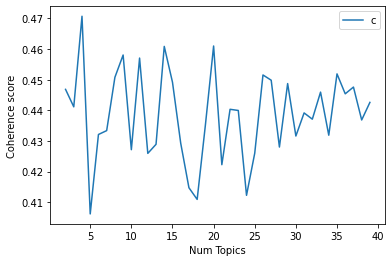

In [ ]:
# Show graph with num of topics vs coherence score
limit=40; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [ ]:
# Print the coherence scores corresponding to no of topics
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4468
Num Topics = 3  has Coherence Value of 0.4411
Num Topics = 4  has Coherence Value of 0.4707
Num Topics = 5  has Coherence Value of 0.4062
Num Topics = 6  has Coherence Value of 0.4321
Num Topics = 7  has Coherence Value of 0.4334
Num Topics = 8  has Coherence Value of 0.4508
Num Topics = 9  has Coherence Value of 0.4581
Num Topics = 10  has Coherence Value of 0.4271
Num Topics = 11  has Coherence Value of 0.4571
Num Topics = 12  has Coherence Value of 0.4259
Num Topics = 13  has Coherence Value of 0.4289
Num Topics = 14  has Coherence Value of 0.4609
Num Topics = 15  has Coherence Value of 0.4492
Num Topics = 16  has Coherence Value of 0.4293
Num Topics = 17  has Coherence Value of 0.4147
Num Topics = 18  has Coherence Value of 0.4109
Num Topics = 19  has Coherence Value of 0.4352
Num Topics = 20  has Coherence Value of 0.461
Num Topics = 21  has Coherence Value of 0.4222
Num Topics = 22  has Coherence Value of 0.4403
Num Topics = 23  has C

In [ ]:
# Select the model and print the topics 
# Model 4 with topic no - 6 has been picked
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.015*"mouse" + 0.011*"pharmacol" + 0.009*"chymase" + 0.008*"lung" + 0.007*"chronic" + 0.006*"role" + 0.005*"autoimmune" + 0.005*"chem" + 0.005*"disease" + 0.005*"inflammation"'),
 (1,
  '0.011*"inflammation" + 0.010*"airway" + 0.009*"asthma" + 0.008*"lung" + 0.008*"patient" + 0.007*"allergic" + 0.006*"immunology" + 0.006*"article" + 0.006*"volume" + 0.006*"response"'),
 (2,
  '0.018*"lung" + 0.014*"respir" + 0.009*"human" + 0.009*"receptor" + 0.007*"’" + 0.006*"antagonist" + 0.006*"muscle" + 0.006*"smooth" + 0.006*"mouse" + 0.006*"resistance"'),
 (3,
  '0.011*"asthma" + 0.009*"study" + 0.008*"mouse" + 0.006*"level" + 0.006*"role" + 0.005*"find" + 0.005*"patient" + 0.005*"control" + 0.005*"increase" + 0.005*"engl"'),
 (4,
  '0.038*"immunol" + 0.022*"receptor" + 0.021*"allergy" + 0.013*"human" + 0.012*"clin" + 0.011*"mouse" + 0.008*"allergic" + 0.007*"activation" + 0.006*"galli" + 0.006*"express"'),
 (5,
  '0.026*"asthma" + 0.021*"mouse" + 0.019*"airway" + 0.018*"leukotriene" + 

In [ ]:
# Visualize the topics - larger bubbles and scattered across all quadrants
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, doc_term_matrix, dictionary)
vis

# Detailed Analysis

In [ ]:
# Finding the dominant topic in each sentence
def format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix, texts=df['Abstract']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9844,"histamine, release, effect, study, increase, m...",three antiallergic drugs doxantrazole well dis...
1,1,1.0,0.9928,"release, histamine, reaction, increase, effect...",decision made therapy atopic eczema complex pa...
2,2,0.0,0.9763,"histamine, release, effect, study, increase, m...",transplantation ascitic mastocytoma intraderma...
3,3,1.0,0.8631,"release, histamine, reaction, increase, effect...",vitro assays release histamine peritoneal show...
4,4,1.0,0.9816,"release, histamine, reaction, increase, effect...",peritoneal concentrate colloidal gold particle...
5,5,1.0,0.9919,"release, histamine, reaction, increase, effect...",role eicosanoids excessive secretion respirato...
6,6,1.0,0.9146,"release, histamine, reaction, increase, effect...",possible rhythmic interaction morphine investi...
7,7,0.0,0.9927,"histamine, release, effect, study, increase, m...",previously established relationship degranulat...
8,8,0.0,0.9905,"histamine, release, effect, study, increase, m...",thermodynamic approach used measure amount hae...
9,9,1.0,0.9660,"release, histamine, reaction, increase, effect...",first event igemediated triggering basophils b...


In [ ]:
# Find the most representative document for each topic 
# i.e. Percentage conribution of topic is max for which document?

sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                      grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                      axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9964,"histamine, release, effect, study, increase, m...",features unlesioned lesioned trochlear nerves ...
1,1.0,0.9947,"release, histamine, reaction, increase, effect...",chemotaxis assays modified boyden chambers use...


In [ ]:
# Topic distribution across documents

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"histamine, release, effect, study, increase, m...",142.0,0.4551
1.0,1.0,"release, histamine, reaction, increase, effect...",170.0,0.5449
2.0,0.0,"histamine, release, effect, study, increase, m...",NaN,NaN
3.0,1.0,"release, histamine, reaction, increase, effect...",NaN,NaN
4.0,1.0,"release, histamine, reaction, increase, effect...",NaN,NaN
...,...,...,...,...
307.0,0.0,"histamine, release, effect, study, increase, m...",NaN,NaN
308.0,1.0,"release, histamine, reaction, increase, effect...",NaN,NaN
309.0,0.0,"histamine, release, effect, study, increase, m...",NaN,NaN
310.0,1.0,"release, histamine, reaction, increase, effect...",NaN,NaN


# Further Work - Pending

### Things to work on :
1) Change data clean up methods to arrive at a better model - Done!

2) Vary the iterations for the data model with best coherence score - Done!

3) Try LDA mallet which is said to yield better results than Gensim LDA - Done!

4) Improve by including BERT into the equation, therefore introducing semantic meaning to LDA's word coherence - Done!

5) Explore SciSpacy - a biomedical text processing library in Python - Done!

6) Remove 'mast' and 'cells' from the corpus - Done!

### Things to work on (List 2) :
1) Extra clean up methods

2) Same method for more papers 